In [14]:
import jax
from jax import numpy as jnp
from jax import random, grad, vmap, jit, tree_multimap, tree_map
from jax.experimental import stax, optimizers
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Tanh, Flatten, LogSoftmax, Softmax

from policy import Policy
from learners import pwl, get_network
from utils import make_plot, make_envs, plot_and_evaluate

from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, axis

import cloudpickle
import h5py

import gym
from gym import wrappers

import io
import base64
from IPython.display import HTML

import numpy as np
import pandas as pd
import sys, os, math, time, pickle, itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
## verify Jax is using the GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [16]:
## Instantiate global rng for reproducability
rng = random.PRNGKey(0)

In [17]:
cartpole_expert_params = tree_map(jnp.array,pickle.load(open('cartpolev1_ppo2_expert.pkl','rb')))
lander_expert_params = tree_map(jnp.array,pickle.load(open('lander_ppo2_expert.pkl','rb')))
hopper_expert_params = tree_map(jnp.array,pickle.load(open('halfcheetah_ppo2_tanh_expert.pkl','rb')))
half_cheetah_expert_params = tree_map(jnp.array,pickle.load(open('halfcheetah_ppo2_tanh_expert.pkl','rb')))

In [18]:
env, envs = make_envs('CartPole-v1')
#env, envs = make_envs('LunarLander-v2')
#env, envs = make_envs('HalfCheetah-v2')
discrete = True

set_state = False
if hasattr(env, 'sim'):
    invert_op = getattr(env.sim, "set_state", None)
    if callable(invert_op):
        set_state = True

env_expert, env_noisy_expert, env_dagger, \
env_active_dagger, env_aggrevate, env_active_aggrevate = envs

max_steps = env.spec.max_episode_steps

init_obs = env.reset()
in_shape = (-1,) + (init_obs.shape[0],)

environments = [env_expert, env_noisy_expert, env_dagger, env_active_dagger, env_aggrevate, env_active_aggrevate]

In [19]:
#expname = './experts/HalfCheetah-v2.pkl'
expert_network = 'cartpole'
expert_params = cartpole_expert_params
net_init_expert, net_apply_expert, net_walk_expert = get_network('{}-expert'.format(expert_network))
#m = cloudpickle.load(open(expname,'rb'))['GaussianPolicy']['obsnorm']['Standardizer']['mean_1_D']
#ms= cloudpickle.load(open(expname,'rb'))['GaussianPolicy']['obsnorm']['Standardizer']['meansq_1_D']
m = 0.0
ms = 1.0
std = np.sqrt(np.maximum(0.0, ms - np.square(m)))

net_init, net_apply, net_walk = get_network('agent-small',outshape=2)

out_shape, init_params = net_init_expert(rng, in_shape)
expert = Policy(rng, in_shape, (net_init_expert, net_apply_expert, net_walk_expert),name='expert', discrete=discrete, trainable=False)
expert.params=expert_params
expert.std_mean = m
expert.std_std = std

In [20]:
n_actions_init = 1
init_action = expert.apply_policy(init_obs)#.flatten()
obs_data = jnp.array([init_obs])
act_data = jnp.array([init_action])
act_data = act_data.reshape(n_actions_init, act_data.shape[1])

In [ ]:
num_episodes = 10
num_rollouts = 25
b = 0.5 # b = 0.5 for , 0.1 for cheetah
dsct_fctr = 0.95

obs_data = jnp.array([init_obs])
act_data = jnp.array([init_action])
act_data = act_data.reshape(n_actions_init, act_data.shape[1])

expert = Policy(rng, in_shape, (net_init_expert, net_apply_expert, net_walk_expert), 
                env=env_expert, name='expert', discrete=discrete, trainable=False)
expert.params = expert_params
#expert.std_mean = m
#expert.std_std = std

dagger = Policy(rng, in_shape, (net_init, net_apply, net_walk),env=env_dagger, name='dagger', discrete=discrete)
active_dagger = Policy(rng, in_shape, (net_init, net_apply, net_walk), 
                       env=env_active_dagger, name='activedagger', discrete=discrete, active=True, constrained=True)
aggrevate = Policy(rng, in_shape, (net_init, net_apply, net_walk),
                   env=env_aggrevate, name='aggrevate', discrete=discrete, cost_sensitive=True)
active_aggrevate = Policy(rng, in_shape, (net_init, net_apply, net_walk),
                          env=env_active_aggrevate, name='activeaggrevate', discrete=discrete, active=True, constrained=True, cost_sensitive=True)

innactive_policies = [expert, dagger, aggrevate]
active_policies = [active_dagger, active_aggrevate]
policies = innactive_policies + active_policies


# aggregate initial data
for policy in policies:
    policy.aggregate((obs_data,act_data))
 
noisy_expert_rewards = []
for i in tqdm(range(num_episodes)): #Dagger main loop
    #cons = random.bernoulli(rng, p=0.1,shape=(dagger.X.shape[0],))
    cons = np.arange(25000)
    constrained_obs = dagger.X[cons,:]
    constrained_act = dagger.y[cons,:]
    
    for policy in policies:
        policy.init_policy()
        if policy.trainable:
            if policy.constrained:
                policy.fit_policy(constraints=(constrained_obs,constrained_act))
            else:
                policy.fit_policy()
            
    new_weights, new_observations, new_actions, \
    active_mask, active_aggrevate_mask, Vs = ([] for _ in range(6))
    
    for j in tqdm(range(num_rollouts), position=1, desc='rollout', leave=False):
        for policy in policies:
            policy.reset_env()
            
        r_t = []
        d_i = 0
        for k in range(max_steps):
            expert_action_logits, expert_action, _ = expert.take_action(dagger.cur_obs)
 
            if i < 2:
                new_observations.append(dagger.cur_obs) 
                new_actions.append(expert_action_logits)
            else:
                if True:#obs_dagger[1] > 0: 
                    
                    ################### Active policies            
                    _, _, active_dagger_conf = active_dagger.take_action(dagger.cur_obs)
                    active_dagger_query = random.bernoulli(rng, p=b/(b + active_dagger_conf.item()))
                    active_mask.append(active_dagger_query or i==0)

                    _,_,active_aggrevate_conf = active_aggrevate.take_action(dagger.cur_obs)
                    active_aggrevate_query = random.bernoulli(rng, p=b/(b + active_aggrevate_conf.item()))
                    active_aggrevate_mask.append(active_aggrevate_query or i==0)
                    ###################

                    new_observations.append(dagger.cur_obs) 
                    new_actions.append(expert_action_logits)
                    
            doneall=True
            for policy in policies:
                obs, r, done = policy.step()
                if policy.name == "expert":
                    r_t.append(r)
                    if done: d_i = k + 1
                if not done: doneall=False
                
            if doneall: break
                
        # need to figure this out
        V = (np.triu(np.power(dsct_fctr,np.tile(np.arange(0,d_i),(d_i,1)) - np.tile(np.arange(0,d_i),(d_i,1)).T))*(-np.array(r_t))).sum(axis=1)
        V = (V - V.mean())/V.std() + 1
        #V = np.clip((V - V.mean())/V.std() + 1,a_min=1e-5,a_max=100)
        Vs.append(V)
        
        for policy in policies:
            policy.rewards[-1].append(policy.reward_accum)
        
    new_observations = np.array(new_observations)
    new_actions = np.array(new_actions)
    active_masks = np.array(active_mask,dtype=np.bool_)
    active_aggrevate_masks = np.array(active_aggrevate_mask,dtype=np.bool_)
    Vs = np.concatenate(Vs)
    
    expert.aggregate((new_observations,new_actions))
    dagger.aggregate((new_observations,new_actions))
    active_dagger.aggregate((new_observations,new_actions),mask=active_mask)
    aggrevate.aggregate((new_observations, new_actions),weights=Vs)
    active_aggrevate.aggregate((new_observations, new_actions),weights=Vs,mask=active_aggrevate_mask)
    
    for policy in policies:
        print('{}: {} {}'.format(policy.name, np.mean(policy.rewards[-1]), policy.num_data[-1]))

/home/chester/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


expert: 500.0 12501
expert: 500.0 12501
dagger: 9.48 12501
aggrevate: 9.48 12501
activedagger: 9.48 12501
activeaggrevate: 9.48 12501


expert: 500.0 25001
expert: 500.0 25001
dagger: 76.44 25001
aggrevate: 60.48 25001
activedagger: 74.72 25001
activeaggrevate: 74.84 25001


expert: 500.0 37501
expert: 500.0 37501
dagger: 20.96 37501
aggrevate: 18.8 37501
activedagger: 25.16 27973
activeaggrevate: 22.36 28351


expert: 500.0 50001
expert: 500.0 50001
dagger: 67.56 50001
aggrevate: 63.16 50001
activedagger: 78.76 37667
activeaggrevate: 73.64 38705


In [ ]:
def plot_and_evaluate():
    make_plot([dagger,expert,active_dagger, aggrevate, active_aggrevate],[('noisy expert',noisy_expert_rewards, expert.num_data)])
    constrained_exp = expert.apply_policy(constrained_obs)
    
    for policy in [dagger,expert,active_dagger, aggrevate, active_aggrevate]:
        constrained = policy.apply_policy(constrained_obs)
        print(policy.name,[np.mean(x) for x in policy.rewards], np.linalg.norm(constrained - constrained_exp), policy.num_data)

In [ ]:
plot_and_evaluate()

In [ ]:
# cartpole
plot_and_evaluate()

dagger 499.0 51.305145
expert 499.0 0.0
activedagger 420.3 99.43368
aggrevate 499.0 56.315155
activeaggrevate 499.0 70.79876


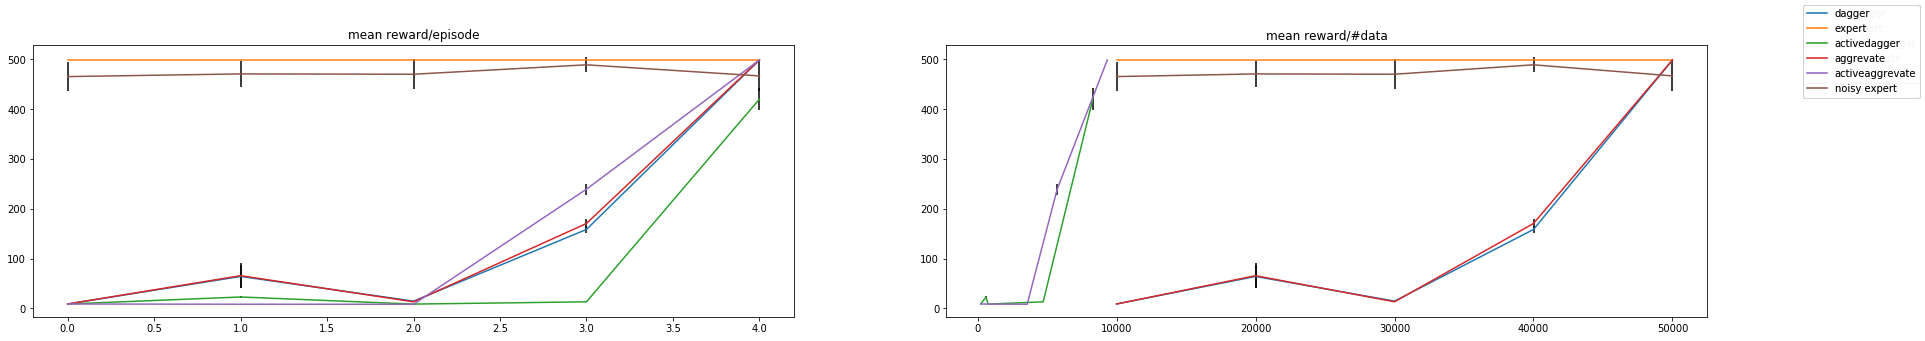

In [22]:
# cartpole
plot_and_evaluate()

In [147]:
active_aggrevate.save('./models/','test_policy_class')

In [150]:
#final_model = './models/{}_active_dagger_model.h5'.format(j)
final_model = './models/test_policy_class.h5'
!xvfb-run -s "-screen 0 600x400x24" python3.6 render.py --mpath $final_model --envname HalfCheetah-v2

100%|███████████████████████████████████████▉| 997/1000 [00:19<00:00, 51.42it/s]


In [151]:
for file in os.listdir("./gym-results/"):
    if file.endswith(".mp4"):   
        mp4name = os.path.join("./gym-results", file)
        print(mp4name)

./gym-results/openaigym.video.0.11286.video000000.mp4


In [152]:
video = io.open(mp4name, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))